In [1]:
import matplotlib
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
%matplotlib inline

class Stereo_Lidar:
    
    def __init__(self, input_dir = './'):
        
        # camera
        self.cam_mats = {"left": None, "right": None}
        self.dist_coefs = {"left": None, "right": None}
        self.rect_rot = {"left": None, "right": None}
        self.proj_mats = {"left": None, "right": None}
        self.undistortion_map = {"left": None, "right": None}
        self.rectification_map = {"left": None, "right": None}
        
        # lidar
        
        self.lidar_rot = None
        self.lidar_trans = None 
        self.T = None
    
        self.read_params(input_dir)
        self.get_undistortmap()
        
    
    def read_params(self,input_dir):
        
        with open(input_dir + 'calib_cam_to_cam.txt') as f :
            
            data = f.readlines()
            data = [item.strip('\n') for item in data]
            data = [item.split(' ') for item in data]
            
            self.cam_mats['left'] = np.array(data[3][1:]).reshape(3,3).astype(np.float64)
            self.cam_mats['right'] = np.array(data[11][1:]).reshape(3,3).astype(np.float64)
            self.dist_coefs['left'] = np.array(data[4][1:]).reshape(1,5).astype(np.float64)
            self.dist_coefs['right'] = np.array(data[12][1:]).reshape(1,5).astype(np.float64)
            self.rect_rot['left'] = np.array(data[8][1:]).reshape(3,3).astype(np.float64)
            self.rect_rot['right']= np.array(data[16][1:]).reshape(3,3).astype(np.float64)
            
            self.proj_mats['left'] = np.array(data[9][1:]).reshape(3,4).astype(np.float64)
            self.proj_mats['right'] = np.array(data[17][1:]).reshape(3,4).astype(np.float64)
            self.image_size = np.array(data[7][1:]).astype(np.float64).astype(np.int64)
            self.image_size = (self.image_size[0],self.image_size[1])
        
        with  open(input_dir + 'calib_cam_to_range_00.txt') as f :
            
            data = f.readlines()
            data = [item.strip('\n') for item in data]
            data = [item.split(' ') for item in data]
            
            self.lidar_rot = np.array(data[2][1:]).reshape(3,3).astype(np.float64)
            self.lidar_trans = np.array(data[3][1:]).reshape(3,1).astype(np.float64)

            self.T = np.c_[self.lidar_rot,self.lidar_trans].astype(np.float64)
            self.T = np.r_[self.T,np.array([0,0,0,1]).reshape(1,4)].astype(np.float64)
        
    def get_undistortmap(self):
        
        for side in ("left", "right"):
            (self.undistortion_map[side],
            self.rectification_map[side]) = cv2.initUndistortRectifyMap(
                                                            self.cam_mats[side],
                                                            self.dist_coefs[side],
                                                            self.rect_rot[side],
                                                            self.proj_mats[side],
                                                            self.image_size,
                                                            cv2.CV_32FC1)
    @staticmethod
    def plot_depth(left,depth,threshold_low,threshold_high):
        
        img = left.copy()
        for i in range(depth.shape[0]):
            for j in range(depth.shape[1]):
                if depth[i,j] > treshold_low and depth[i,j] < threshold_high:
                    cv2.circle(img,(j,i),2,255)
                    
        kernel = np.ones((3, 3), np.float32) / 25
        dst = cv2.filter2D(depth, -1, kernel)
        plt.figure()
        plt.imshow(img)
        plt.colorbar()
        
    def rectify(self, frames):
        """
            Rectify frames passed as (left, right, lidar) 
            
            return :
                img1_undistort,img2_undirstort,depth_undistort,disparity_undistort
        """
        k1 = self.dist_coefs['left'][0][0]
        k2 = self.dist_coefs['left'][0][1]
        p1 = self.dist_coefs['left'][0][2]
        p2 = self.dist_coefs['left'][0][3]
        k3 = self.dist_coefs['left'][0][4]
        
        origin_shape = frames[0].shape
        new_frames = []
        
        # undistort image
        for i, side in enumerate(("left", "right")):
            new_frames.append(cv2.remap(frames[i],
                                        self.undistortion_map[side],
                                        self.rectification_map[side],
                                        cv2.INTER_NEAREST))
            
        # get distortion depth
        position = []
        for tmp_point in frames[2]:
            tmp = np.linalg.solve(self.lidar_rot,(tmp_point.reshape(3,1) - self.lidar_trans))
            tmp = tmp.reshape(3,)
            tmp[0] = tmp[0] / tmp[2]
            tmp[1] = tmp[1] / tmp[2]
            
            x = tmp[0]
            y = tmp[1]
            r = (x**2+y**2)**0.5
            x = x*(1+k1*r**2+k2*r**4)+p2*(r**2+2*x**2) + 2*p1*x*y
            y = y*(1+k1*r**2+k2*r**4)+p1*(r**2+2*y**2) + 2*p2*x*y
            
            x = x * self.cam_mats['left'][0,0] + self.cam_mats['left'][0,2]
            y = y * self.cam_mats['left'][1,1] + self.cam_mats['left'][1,2]
            position.append((x,y))
        
        position = np.array(position)
        depth = np.zeros(origin_shape[:2])
            
        for i,point in enumerate(position):
            x = int(round(point[0]))
            y = int(round(point[1] ))
            if y <  origin_shape[0] and y>0 and x<origin_shape[1] and x>0 and  frames[2][i][0] > 0:
                depth[y,x] = frames[2][i][0] 
                
        # undistort depth
        depth = cv2.remap(depth,
                                        self.undistortion_map['left'],
                                        self.rectification_map['left'],
                                        cv2.INTER_NEAREST)
        new_frames.append(depth)
        
        # get disparity from depth 
        disparity = np.ones(depth.shape) * -1
        disparity = np.where(depth>0,(789.68925*0.57)/depth,-1)
        
        for i in range(disparity.shape[0]):
            for j in range(disparity.shape[1]):
                if disparity[i,j]>0:
                    disparity[i,j] = -1 if j-disparity[i,j]<=0 else disparity[i,j]
        new_frames.append(disparity)
        return new_frames

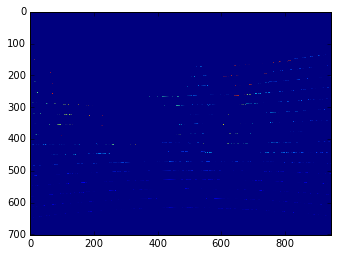

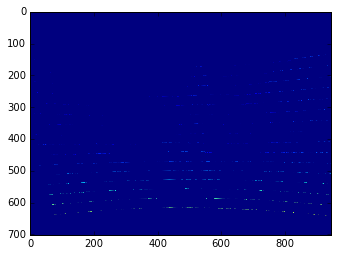

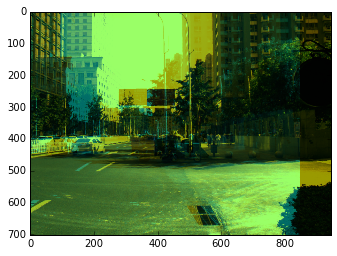

In [3]:
img1 = cv2.imread('/home/xudong/cam_lidar_data_0819/160744/cam/i00000001_cam1_1471594109.966772_1471594065.290156.jpg')
img2 = cv2.imread('/home/xudong/cam_lidar_data_0819/160744/cam/i00000001_cam2_1471594109.966772_1471594065.258702.jpg')
lidar = pd.read_csv('/home/xudong/cam_lidar_data_0819/160744/lidar/i00000001_1471594109.943019.csv',header=None,sep=' ')
lidar = lidar.values

calibration = Stereo_Lidar('/home/xudong/calibration/result_example/')
ret = calibration.rectify((img1,img2,lidar))

plt.figure()
plt.imshow(ret[2])
plt.figure()
plt.imshow(ret[3])

ret[0][:,:,0] = 0
ret[1][:,:,2] = 0
M = np.float32([[1, 0, -100], [0, 1, 0]])
ret[0]= cv2.warpAffine(ret[0], M, (ret[0].shape[1], ret[0].shape[0]))

img = cv2.addWeighted(ret[0],0.4,ret[1],0.6,1)
plt.figure()
plt.imshow(img)

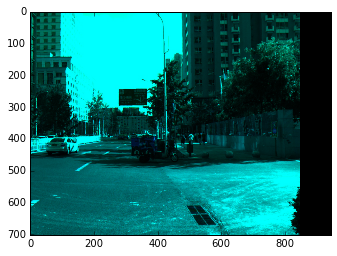

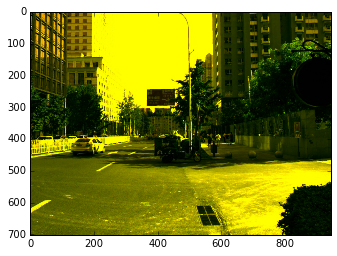

In [5]:
plt.imshow(ret[0])
plt.figure()
plt.imshow(ret[1])

In [ ]:
plt.waitforbuttonpress()

In [74]:
ret = calibration.rectify((img1,img2,lidar))


In [6]:
ret[0].shape

(702, 945, 3)

600 143 59.5663782239
600 837 64.1591749479
600 841 64.357185736


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


600 845 64.4420286939
601 129 59.878655626
601 132 59.7991865563
601 136 59.7495862817
601 139 59.700873592
601 848 64.6758631686
601 852 64.697101283
601 856 64.895523026
602 115 60.2790037223
602 119 60.1810340548
602 122 59.9823374755
602 126 59.9155486219
602 859 65.1341414999
602 863 65.2800856201
602 871 65.4814933236
602 874 65.6705638912
602 877 65.9286945227
603 101 60.588493746


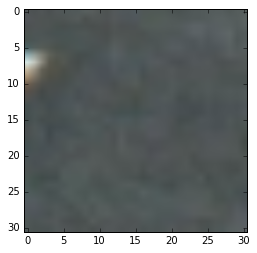

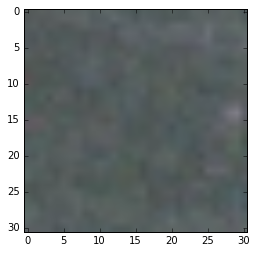

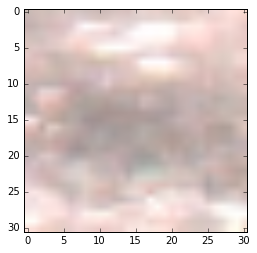

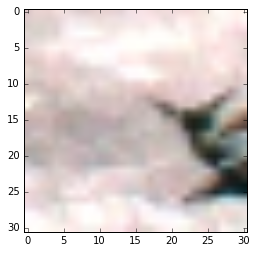

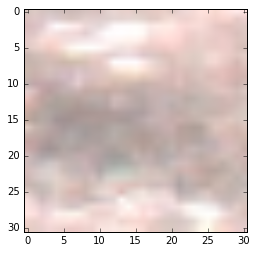

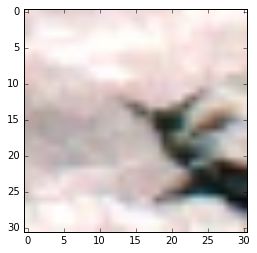

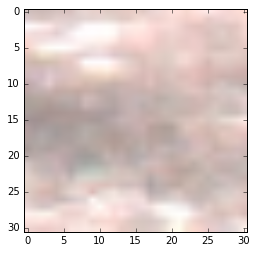

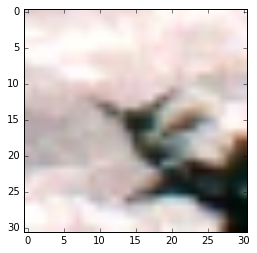

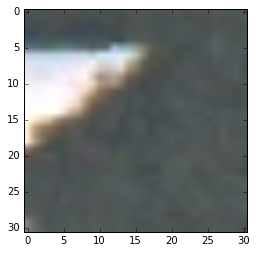

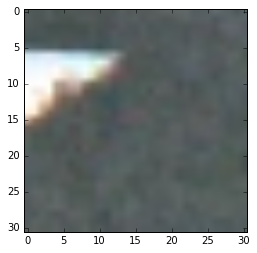

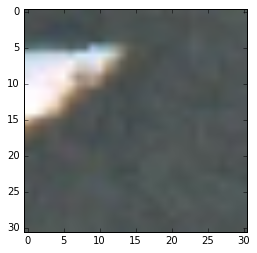

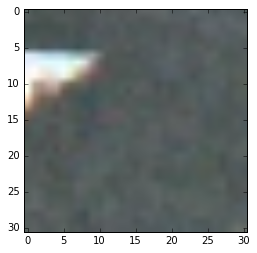

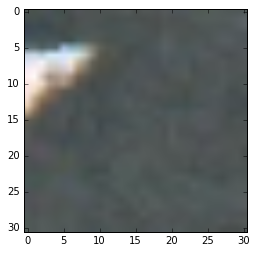

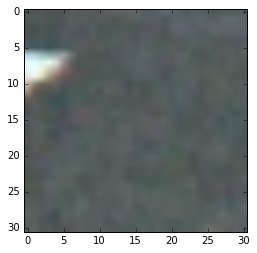

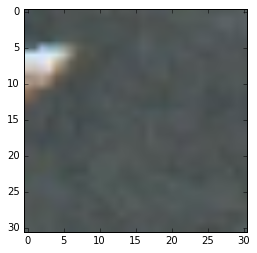

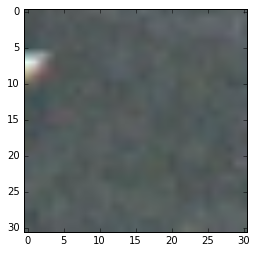

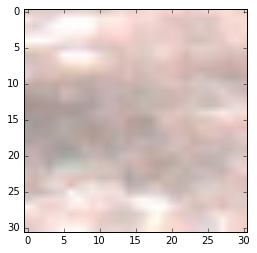

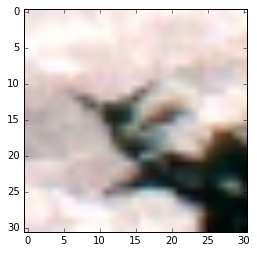

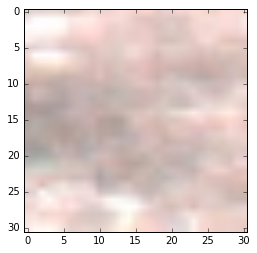

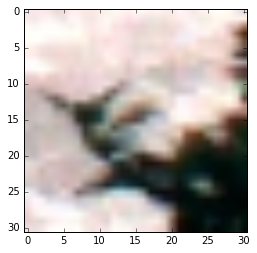

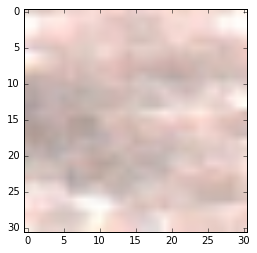

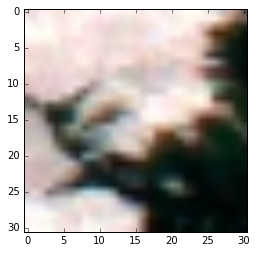

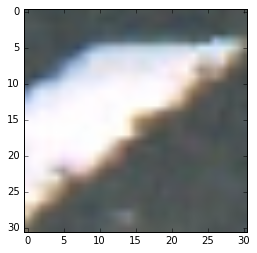

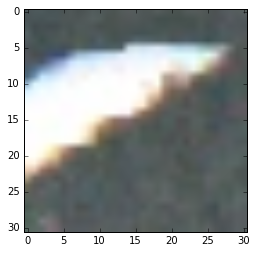

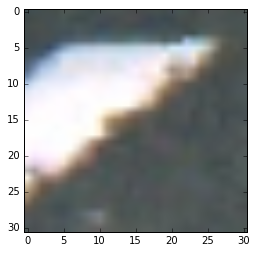

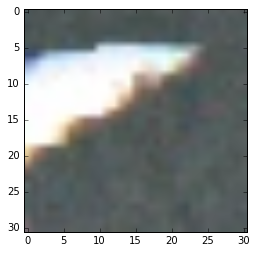

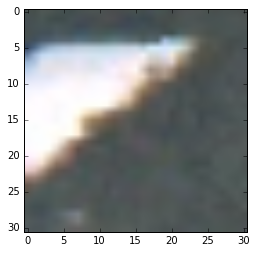

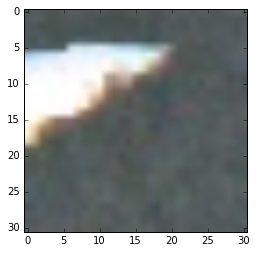

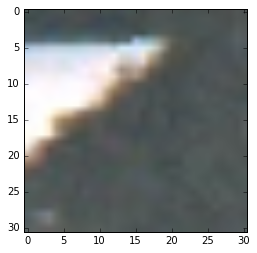

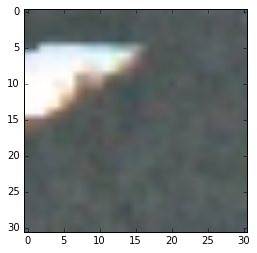

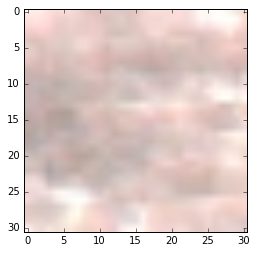

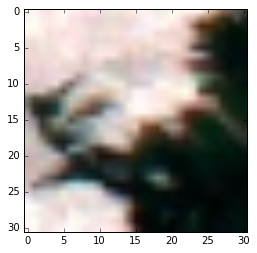

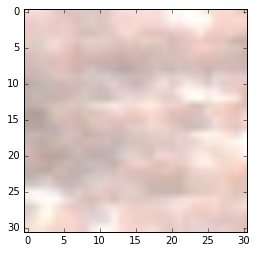

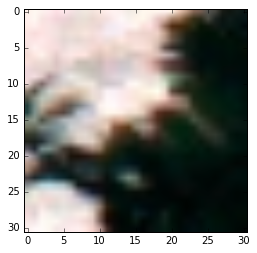

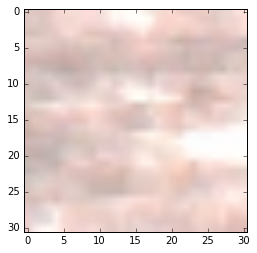

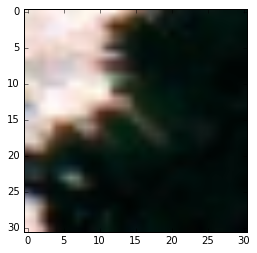

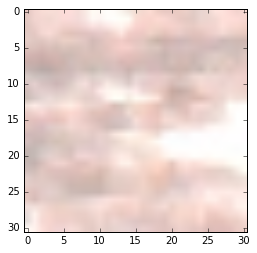

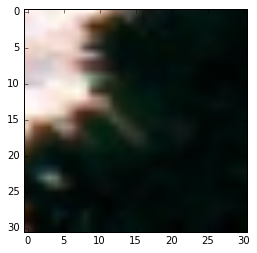

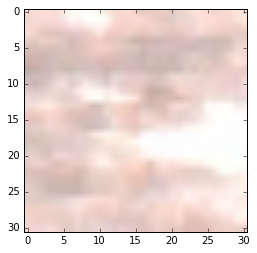

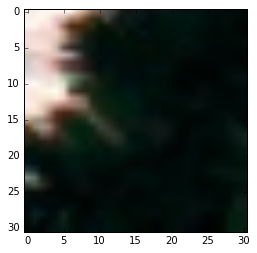

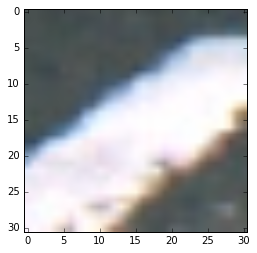

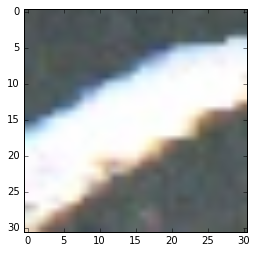

In [75]:
check_data(ret[0],ret[1],ret[3])